In [2]:
from msresist.pre_processing import preprocessing
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
from msresist.figures.figure1 import import_phenotype_data, formatPhenotypesForModeling
from msresist.clustering import MassSpecClustering
from msresist.figures.figure2 import plotStripActualVsPred, plotScoresLoadings, plotDistanceToUpstreamKinase, ComputeCenters, plotCenters, plotMotifs
from sklearn.cross_decomposition import PLSRegression

In [3]:
sns.set(style="whitegrid", font_scale=1.2, color_codes=True, palette="colorblind", rc={"grid.linestyle": "dotted", "axes.linewidth": 0.6})

In [4]:
# Import phenotypes
cv = import_phenotype_data(phenotype="Cell Viability")
red = import_phenotype_data(phenotype="Cell Death")
sw = import_phenotype_data(phenotype="Migration")
c = import_phenotype_data(phenotype="Island")
y = formatPhenotypesForModeling(cv, red, sw, c)
y = y[y["Treatment"] == "A/E"].drop("Treatment", axis=1).set_index("Lines")

# Mass Spec data
X = preprocessing(AXLm_ErlAF154=True, Vfilter=True, FCfilter=True, log2T=True, mc_row=True)
d = X.select_dtypes(include=['float64']).T
i = X.select_dtypes(include=['object'])

In [5]:
import pickle

with open("msresist/data/pickled_models/AXLmodel_PAM250_W2-5_5CL", "rb") as m:
    model = pickle.load(m)
centers = model.transform()

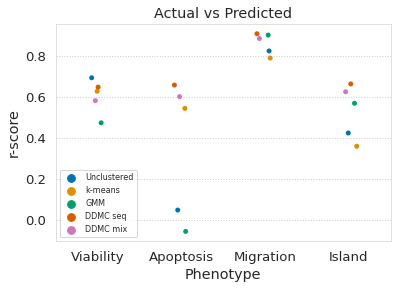

In [6]:
# Predictions
Xs, models = ComputeCenters(X, d, i, model, model.ncl)
Xs.append(centers)
models.append("DDMC mix")

_, ax = plt.subplots(1, 1)
plotStripActualVsPred(ax, [3, 4, 2, 3, 4], Xs, y, models)

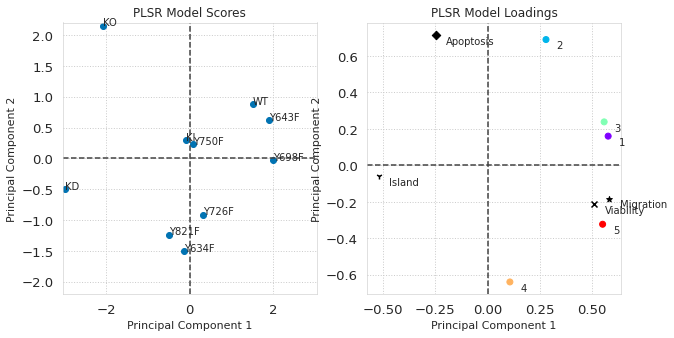

In [7]:
# Scores & Loadings
lines = ["WT", "KO", "KD", "KI", "Y634F", "Y643F", "Y698F", "Y726F", "Y750F ", "Y821F"]
plsr = PLSRegression(n_components=4)
_, ax = plt.subplots(1, 2, figsize=(10, 5))
plotScoresLoadings(ax, plsr.fit(centers, y), centers, y, model.ncl, lines, pcX=1, pcY=2)

/home/marcc/resistance-MS/msresist/figures/figure2.py:246: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[i].set_xticklabels(xlabels, rotation=45)
/home/marcc/resistance-MS/msresist/figures/figure2.py:246: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[i].set_xticklabels(xlabels, rotation=45)
/home/marcc/resistance-MS/msresist/figures/figure2.py:246: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[i].set_xticklabels(xlabels, rotation=45)
/home/marcc/resistance-MS/msresist/figures/figure2.py:246: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[i].set_xticklabels(xlabels, rotation=45)
/home/marcc/resistance-MS/msresist/figures/figure2.py:246: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[i].set_xticklabels(xlabels, rotation=45)


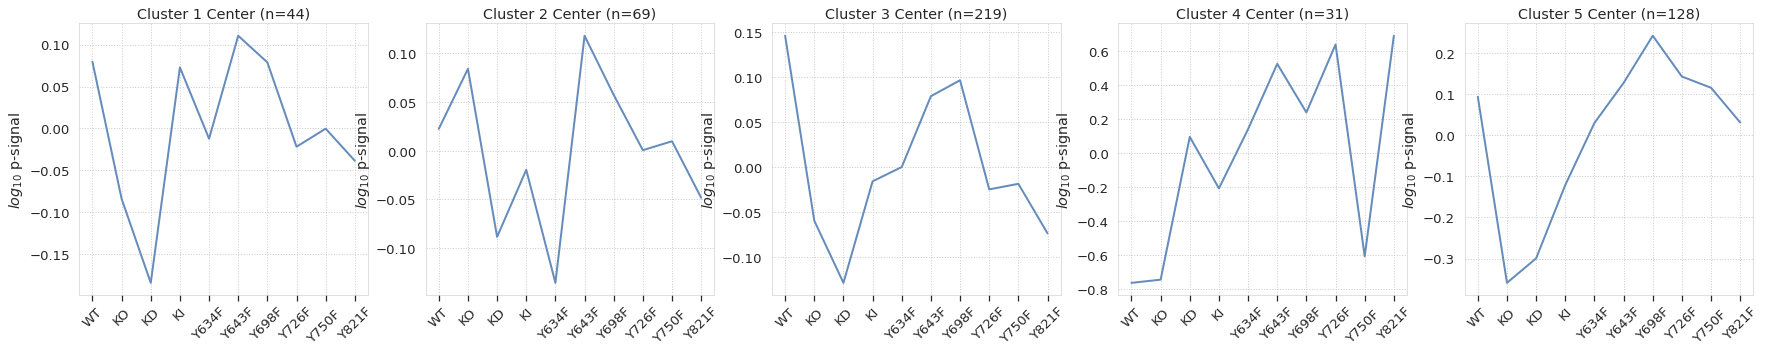

In [8]:
_, ax = plt.subplots(1, 5, figsize=(30, 5))
lines = ["WT", "KO", "KD", "KI", "Y634F", "Y643F", "Y698F", "Y726F", "Y750F ", "Y821F"]
plotCenters(ax, model, lines)

/home/marcc/resistance-MS/msresist/clustering.py:159: RuntimeWarning: divide by zero encountered in log2
  pssm.loc[p_site, 5] = np.log2(clSeq.loc[p_site, 5] / tm)
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


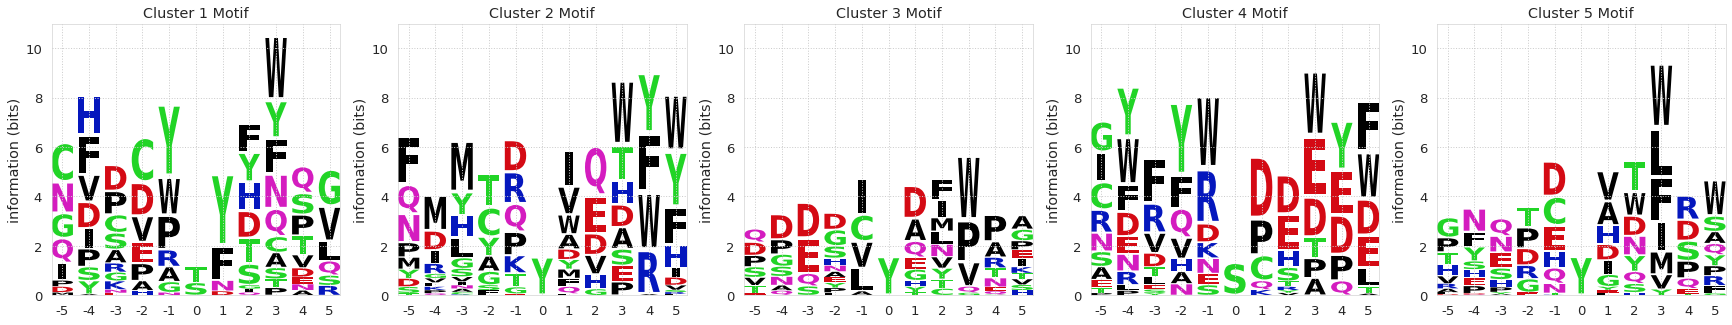

In [9]:
_, ax = plt.subplots(1, 5, figsize=(30, 5))
pssms = model.pssms(PsP_background=True)
plotMotifs([pssms[0], pssms[1], pssms[2], pssms[3], pssms[4]], axes=ax, titles=["Cluster 1", "Cluster 2", "Cluster 3", "Cluster 4", "Cluster 5"], yaxis=[0, 11])

/home/marcc/resistance-MS/msresist/clustering.py:159: RuntimeWarning: divide by zero encountered in log2
  pssm.loc[p_site, 5] = np.log2(clSeq.loc[p_site, 5] / tm)
No handles with labels found to put in legend.


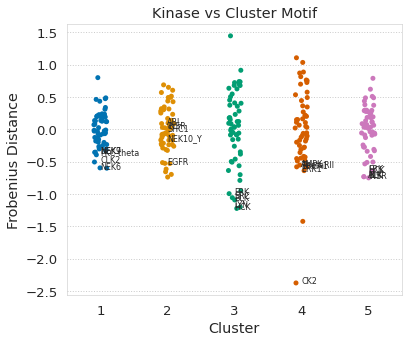

In [10]:
_, ax = plt.subplots(1, 1, figsize=(6, 5))
plotDistanceToUpstreamKinase(model, [1, 2, 3, 4, 5], ax, num_hits=5)